## Автоматизация отчетности

<b>Цель:</b> создать отчет по основным данным, который будет отправляться в чат с ботом каждый день в 11 утра.

<b>Задачи:<b>
 - Создать бот в телеграмм с помощью BotFather;
 - Отправка ботом ежедневного отчета по лайкам, просмотрам, DAU, CTR;
 - Отправка ботом с графиками тех же данныз за последние 7 дней;
 
Код сборки и отправки отчета:

In [2]:
import telegram
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import io
from airflow import DAG
from datetime import datetime
from datetime import timedelta
from airflow.decorators import dag, task
from IPython.display import Image

default_args = {
    'owner': 'd-tsykarev-13',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2022, 12, 15)
}

schedule_interval = '0 11 * * *'

@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False, tags=['d-tsykarev'])
def get_last_feed_data():

    @task()
    def extract():
        connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

        query = '''
        SELECT toDate(time) as date,
                uniq(user_id) as DAU,
                countIf(action == 'like') as likes,
                countIf(action == 'view') as views,
                likes/views as CTR
        FROM simulator_20221120.feed_actions
        WHERE (toDate(time) >= today() - INTERVAL 7 day) AND (toDate(time) != today())
        GROUP BY toDate(time)
        '''

        df = ph.read_clickhouse(query, connection=connection)
        return df
    
    @task()
    def load(df):
        my_token = '5817720440:AAGEIaTOdG1oZkbVURVBsLNMMzcfV8Vr814'
        bot = telegram.Bot(token=my_token)
        chat_id = -817095409
        
        ### Отправляем текстовую часть
        text = 'Дата: {} \n DAU: {} \n Views: {} \n Likes: {} \n CTR: {:.2%}'\
        .format(
            df['date'].max().date(), 
            df[df['date'] == df['date'].max()]['DAU'].iloc[0],
            df[df['date'] == df['date'].max()]['views'].iloc[0],
            df[df['date'] == df['date'].max()]['likes'].iloc[0],
            df[df['date'] == df['date'].max()]['likes'].iloc[0]/df[df['date'] == df['date'].max()]['views'].iloc[0]
        )
        bot.sendMessage(chat_id=chat_id, text=text)
        
        
        ### Создаем общую фигуру
        fig, axs = plt.subplots(3, 1)
        fig.set_size_inches(12, 12)
        
        ### Лайки и просмотры
        sns.lineplot(data = df, x = 'date', y = 'views', ax=axs[0], label = 'views')
        sns.lineplot(data = df, x = 'date', y = 'likes', ax=axs[0], label = 'likes')
        axs[0].set_ylabel('actions')
        axs[0].set_xlabel('')
        axs[0].set_title('actions')
        
        ### DAU
        sns.lineplot(data = df, x = 'date',  y = 'DAU', ax=axs[1], label = 'DAU')
        axs[1].set_ylabel('users')
        axs[1].set_xlabel('')
        axs[1].set_ylim(0, df['DAU'].max() + 5000)
        
        ### CTR
        sns.lineplot(data = df, x = 'date', y = 'CTR', ax=axs[2], label = 'CTR')
        axs[2].set_ylabel('CTR')
        axs[2].set_ylim(0, df['CTR'].max() + 0.1)
        
        ### Отправляем в чат
        plot_object = io.BytesIO()
        plt.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = 'feed_data_plot.png'
        plt.close()
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)
        
    df = extract()
    load(df)        
        
    
get_last_feed_data = get_last_feed_data()

### Пример отчета:

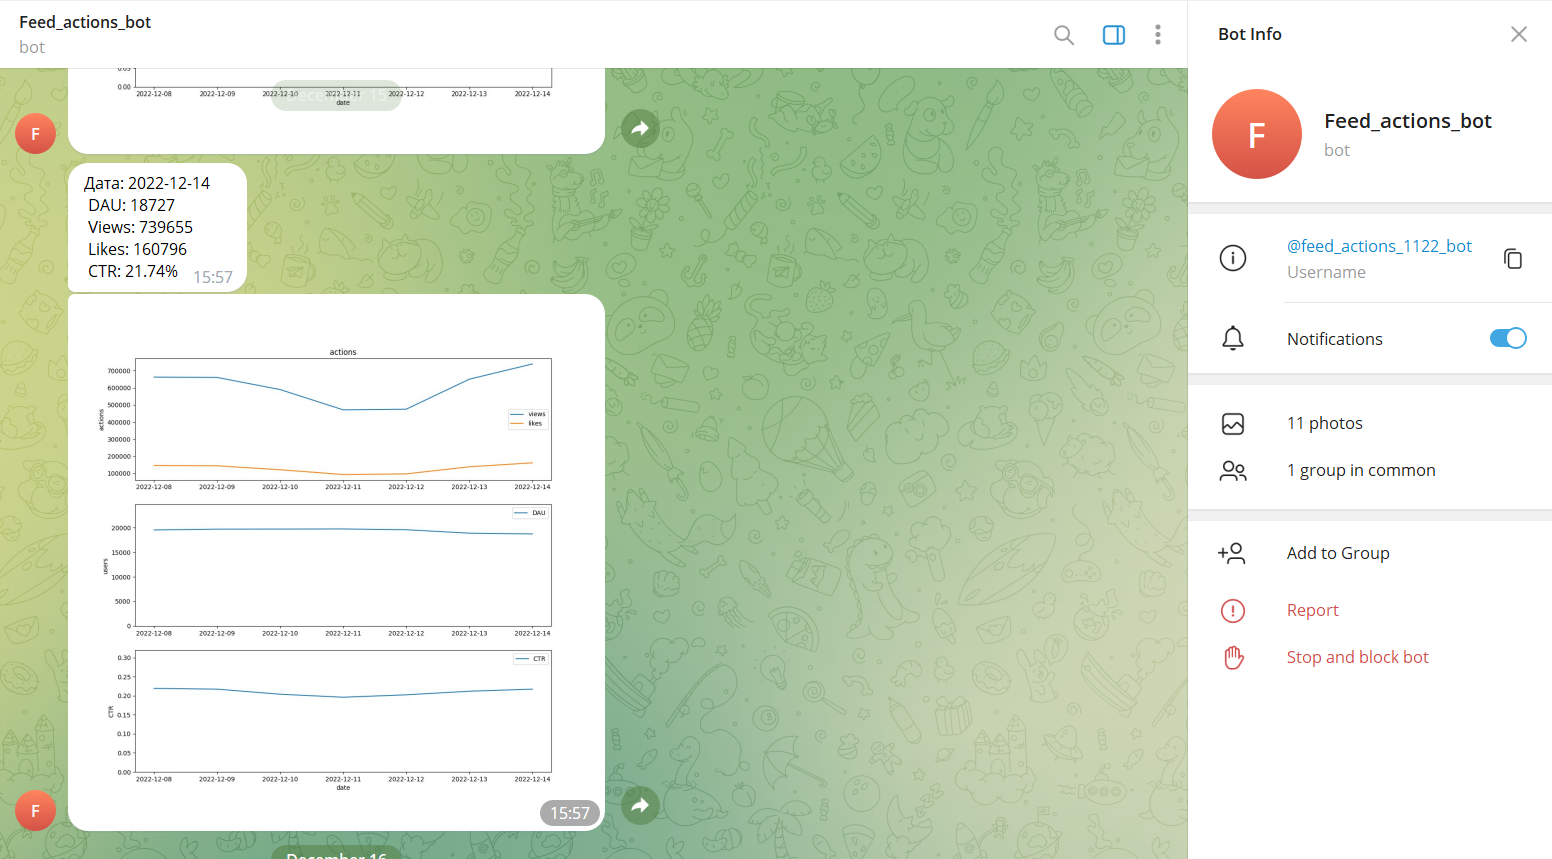

In [4]:
Image("Screenshot_7.png", width=1552, height=859)